In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

import sklearn
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from jupyterthemes import jtplot
jtplot.style('monokai')



# Load and Scale Data

In [2]:
pddata_train = pd.read_csv('Data/sign_mnist_train.csv')
data_train = pddata_train.values
data_train_X = data_train[:,1:]
data_train_y = data_train[:,:1].reshape(-1) # turn to 1d


pddata_test = pd.read_csv('Data/sign_mnist_test.csv')
data_test = pddata_test.values
data_test_X = data_test[:, 1:]
data_test_y = data_test[:, :1].reshape(-1) # turn to 1d

In [ ]:
mmscaler = MinMaxScaler()
mmscaled_train_X = mmscaler.fit_transform(data_train_X)
mmscaled_test_X = mmscaler.transform(data_test_X)

stdscaler = StandardScaler()
stdscaled_train_X = stdscaler.fit_transform(data_train_X)
stdscaled_test_X = stdscaler.transform(data_test_X)

In [3]:
print(data_train_X.shape)

(27455, 784)


# Logistic Regression

In [12]:
def logreg(penalty: str='l2', solver: str='lbfgs', r=None, verbose: bool=False) -> None:
    # place to store results
    train_accs = []
    test_accs = []
    cs = []

    for exponent in (r if r is not None else range(-3,3+1, 2)):
        if verbose:
            print(f'loop: {exponent}')
            
        c_value = 10**exponent
        cs.append(c_value) # store, to graph


        logreg = LogisticRegression(max_iter=10000, C=c_value, penalty=penalty, solver=solver, verbose=verbose)

        logreg.fit(scaled_train_X, data_train_y.reshape(-1)) # fit model 

        # store results
        train_accs.append(np.mean(np.equal(logreg.predict(scaled_train_X), data_train_y))) # train accuuracy
        test_accs.append(np.mean(np.equal(logreg.predict(scaled_test_X), data_test_y)))  # test accuracy

        if verbose:
            print(f"train: {train_accs[-1]}")
            print(f"test: {test_accs[-1]}")

    
    plt.title(f"Accuracies v. c value, {penalty} regularization")
    plt.xlabel("C values")
    plt.ylabel("Accuracy")
    plt.xscale('log')
    plt.plot(cs, train_accs, label='train')
    plt.plot(cs, test_accs, label='test')
    plt.legend(loc='lower right')
    plt.show()

loop: -3
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
train: 0.6450919686760153
test: 0.5344394868934746
loop: -1
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
train: 0.9920233108723365
test: 0.7025934188510876
loop: 1
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
train: 1.0
test: 0.6864194088120469
loop: 3
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished
train: 1.0
test: 0.6827941996653654


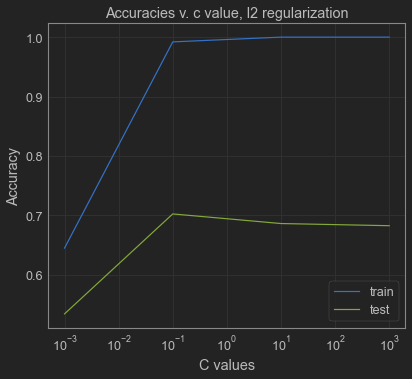

In [13]:
logreg(penalty='l2', verbose=True)

In [103]:
# logreg(penalty='l1', solver='saga', r=(-2,3),verbose=True)

In [104]:
logreg = LogisticRegression(max_iter=10, penalty='l1', solver='saga')
print('a')
logreg.fit(scaled_train_X, data_train_y.reshape(-1)) # fit model 
print(np.mean(np.equal(logreg.predict(scaled_test_X), data_test_y)))

# Support Vector Machine

In [6]:
def SVM(penalty=None, kernel='linear', r=None, verbose: bool=False) -> None:
    train_accs = []
    test_accs = []
    cs = []
    
    for exponent in (r if r is not None else range(-3,3+1, 2)):
        if verbose:
            print(f'loop: {exponent}')
            
        c = 10**exponent
        cs.append(c) # store, to graph

        S = svm.SVC(probability=False, max_iter=1000, kernel=kernel, C=c, verbose=verbose)
        
        S.fit(scaled_train_X, data_train_y)

        train_accs.append(np.mean(np.equal(S.predict(scaled_train_X), data_train_y))) # train accuuracy
        test_accs.append(np.mean(np.equal(S.predict(scaled_test_X), data_test_y)))  # test accuracy


    plt.title(f"Accuracies v. c value, {penalty} regularization")
    plt.xlabel("C values")
    plt.ylabel("Accuracy")
    plt.xscale('log')
    plt.plot(cs, train_accs, label='train')
    plt.plot(cs, test_accs, label='test')
    plt.legend(loc='lower right')
    plt.show()


loop: -3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: -1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler 

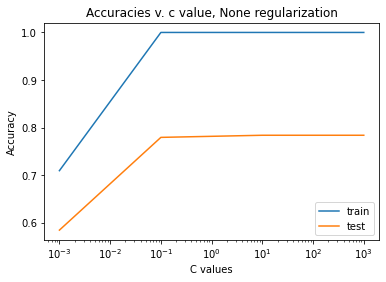

In [7]:
SVM(kernel='linear', verbose=True)

loop: -3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: -1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler 

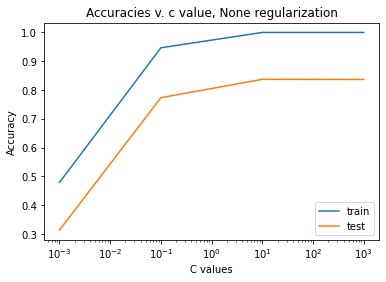

In [8]:
SVM(kernel='rbf', verbose=True)

loop: -3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: -1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 1
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
loop: 3
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler 

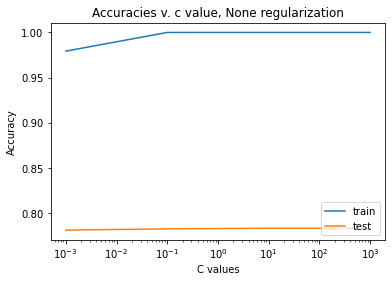

In [9]:
SVM(kernel='poly', verbose=True)

In [109]:
# print('break1')
# a = svm.SVC(max_iter=100, probability=False, kernel='rbf')
# print('break2')
# a.fit(scaled_train_X, data_train_y)
# print('break3')
# print(np.mean(np.equal(a.predict(scaled_train_X), data_train_y))) # train accuuracy
# print(np.mean(np.equal(a.predict(scaled_test_X), data_test_y)))  # test accuracy


break1
break2
C:\Users\liheng\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
break3
0.9938808960116554
0.8353318460680423


In [17]:
# print('break1')
# a = svm.SVC(max_iter=10000, probability=False, kernel='poly', degree=2)
# print('break2')
# a.fit(scaled_train_X, data_train_y)
# print('break3')
# print(np.mean(np.equal(a.predict(scaled_train_X), data_train_y))) # train accuuracy
# print(np.mean(np.equal(a.predict(scaled_test_X), data_test_y)))  # test accuracy

break1
break2
break3
1.0
0.795872838817624
